In [45]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import copy
from scipy import stats
from sklearn.preprocessing import LabelEncoder
from scipy.stats import describe, skew, kurtosis
!pip install imblearn
from sklearn.decomposition import PCA
from boostaroota import BoostARoota
from sklearn.metrics import roc_auc_score, log_loss
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
import catboost as cat_
from sklearn.metrics import accuracy_score
# import lightgbm as lgb
import xgboost as xgb
%matplotlib inline
from individual_data_formatter import generate_formatted_children_under_five 

In [46]:
individual_recode = generate_formatted_children_under_five()

/Users/saheedfaremi/Library/CloudStorage/OneDrive-Etihuku/malariaDemographic/modelling/individual_data_formatter.py:12: DtypeWarning: Columns (48,65,74,82,84,85,86,87,88,89,90,91,128,129,130,131,132,133,134,135,136,142,143,149,150,163,164,198,199,203,204,205,206,212,213,220,228,234) have mixed types. Specify dtype option on import or set low_memory=False.
  individual_recode = pd.read_csv('../data/generate/individual_house_hold_recode.csv')


In [47]:
individual_recode.head()

,Unnamed: 0,HHID Case Identification,HV000 Country code and phase,HV001 Cluster number,HV002 Household number,HV003 Respondent's line number (answering Household questionnaire),HV004 Ultimate area unit,HV005 Household sample weight (6 decimals),HV006 Month of interview,HV007 Year of interview,...,HML37F$01 Suffer from illnesssymptom: abnormal bleeding,HML37G$01 Suffer from illnesssymptom: jaundice or yellow skin,HML37H$01 Suffer from illnesssymptom: dark urine,HML37I$01 Suffer from illnesssymptom: vomiting,HML37J$01 Suffer from illnesssymptom: pallor,HML37K$01 Suffer from illnesssymptom: refusal to eat,HML37L$01 Suffer from illnesssymptom: very cold hands and feet,HML38$01 Child taken or taking first line medicine given by health provider for malaria,HML39$01 Parent accept first line medicine to treat malaria,HML40$01 Fieldworker provided first line medicine for malaria
9,0,1 1,NG8,1.0,1.0,3.0,1.0,1119345.0,10.0,2021.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,0,1 1,NG8,1.0,1.0,3.0,1.0,1119345.0,10.0,2021.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13,0,1 1,NG8,1.0,1.0,3.0,1.0,1119345.0,10.0,2021.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21,2,1 8,NG8,1.0,8.0,3.0,1.0,1119345.0,10.0,2021.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
31,3,1 11,NG8,1.0,11.0,3.0,1.0,1119345.0,10.0,2021.0,...,No,No,No,No,Yes,Yes,No,NaN,NaN,NaN


In [48]:
children_under_5 = copy.deepcopy(individual_recode)

In [49]:
children_under_5['HML32$01 Final result of malaria from blood smear test'].describe()

count        10655
unique           2
top       Negative
freq          8390
Name: HML32$01 Final result of malaria from blood smear test, dtype: object

In [50]:
children_under_5['HML32$01 Final result of malaria from blood smear test'].value_counts()

HML32$01 Final result of malaria from blood smear test
Negative    8390
Positive    2265
Name: count, dtype: int64

In [51]:
print(2265/(8390+2265))

0.21257625527921165


In [52]:

household_Information = [
    'HV004    Ultimate area unit',
    'HV009    Number of household members', 'HV010    Number of eligible women in household',
    'HV012    Number of de jure members', 'HV013    Number of de facto members',
    'HV014    Number of children 5 and under (de jure)', 
]
household_characteristics = [
    'HV204    Time to get to water source (minutes)', 'HV205    Type of toilet facility', 'HV206    Has electricity',
    'HV207    Has radio', 'HV208    Has television', 'HV209    Has refrigerator', 'HV210    Has bicycle',
    'HV211    Has motorcyclescooter', 'HV212    Has cartruck', 'HV213    Main floor material',
    'HV214    Main wall material', 'HV215    Main roof material', 'HV216    Number of rooms used for sleeping',
    'HV219    Sex of head of household', 'HV220    Age of head of household',
    'HV221    Has telephone (land-line)', 'HV222    Type of cookstove', 'HV225    Share toilet with other households',
    'HV227    Has mosquito bed net for sleeping', 'HV228    Children under 5 slept under mosquito bed net last night',
    'HV235    Location of source for water', 'HV238    Number of households sharing toilet',
    'HV244    Owns land usable for agriculture', 'HV245    Hectares of agricultural land (1 decimal)',
    'HV246    Owns livestock, herds or farm animals', 'HV247    Has bank account', 'HV270    Wealth index combined',
    'HV222    Type of cookstove', 'HV227    Has mosquito bed net for sleeping',
    'HV228    Children under 5 slept under mosquito bed net last night', 'HV238    Number of households sharing toilet',
    'HV245    Hectares of agricultural land (1 decimal)', 'HV246    Owns livestock, herds or farm animals',
    'HV246A   Owns cattle', 'HV246B   Owns cows bulls', 'HV246C   Owns horses donkeys mules', 'HV246D   Owns goats',
    'HV246E   Owns sheep', 'HV246F   Owns chickenspoultry', 'HV246G   Owns pigs', 'HV246H   Owns camels'
]


bed_net_usage_and_malaria = [
    'HML1     Number of mosquito bed nets'
]

socio_economic_factors = household_Information + household_characteristics + bed_net_usage_and_malaria
#removing duplicates
socio_economic_factors = sorted(set(socio_economic_factors))


In [53]:
children_under_5[socio_economic_factors].head()

,HML1 Number of mosquito bed nets,HV004 Ultimate area unit,HV009 Number of household members,HV010 Number of eligible women in household,HV012 Number of de jure members,HV013 Number of de facto members,HV014 Number of children 5 and under (de jure),HV204 Time to get to water source (minutes),HV205 Type of toilet facility,HV206 Has electricity,...,HV246A Owns cattle,HV246B Owns cows bulls,HV246C Owns horses donkeys mules,HV246D Owns goats,HV246E Owns sheep,HV246F Owns chickenspoultry,HV246G Owns pigs,HV246H Owns camels,HV247 Has bank account,HV270 Wealth index combined
9,0.0,1.0,14.0,3.0,14.0,14.0,3.0,2.0,Flush to septic tank,Yes,...,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,Yes,Richer
10,0.0,1.0,14.0,3.0,14.0,14.0,3.0,2.0,Flush to septic tank,Yes,...,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,Yes,Richer
13,0.0,1.0,14.0,3.0,14.0,14.0,3.0,2.0,Flush to septic tank,Yes,...,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,Yes,Richer
21,2.0,1.0,6.0,2.0,6.0,6.0,1.0,On premises,Flush to septic tank,No,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes,Middle
31,1.0,1.0,9.0,2.0,9.0,9.0,2.0,On premises,Flush to septic tank,Yes,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes,Middle


In [54]:
demographic_factors = [
    'HV009    Number of household members', 'HV010    Number of eligible women in household',
    'HV012    Number of de jure members', 'HV013    Number of de facto members',
    'HV014    Number of children 5 and under (de jure)',
    'HV220    Age of head of household',
    'HV219    Sex of head of household'
]
demographic_factors = sorted(set(demographic_factors))

# Machine Learning

In [55]:
children_under_5[demographic_factors].head()

,HV009 Number of household members,HV010 Number of eligible women in household,HV012 Number of de jure members,HV013 Number of de facto members,HV014 Number of children 5 and under (de jure),HV219 Sex of head of household,HV220 Age of head of household
9,14.0,3.0,14.0,14.0,3.0,Male,50.0
10,14.0,3.0,14.0,14.0,3.0,Male,50.0
13,14.0,3.0,14.0,14.0,3.0,Male,50.0
21,6.0,2.0,6.0,6.0,1.0,Male,38.0
31,9.0,2.0,9.0,9.0,2.0,Male,41.0


In [56]:
demo_socio_data = children_under_5[sorted(set(demographic_factors + socio_economic_factors))]

In [57]:
demo_socio_data.head()

,HML1 Number of mosquito bed nets,HV004 Ultimate area unit,HV009 Number of household members,HV010 Number of eligible women in household,HV012 Number of de jure members,HV013 Number of de facto members,HV014 Number of children 5 and under (de jure),HV204 Time to get to water source (minutes),HV205 Type of toilet facility,HV206 Has electricity,...,HV246A Owns cattle,HV246B Owns cows bulls,HV246C Owns horses donkeys mules,HV246D Owns goats,HV246E Owns sheep,HV246F Owns chickenspoultry,HV246G Owns pigs,HV246H Owns camels,HV247 Has bank account,HV270 Wealth index combined
9,0.0,1.0,14.0,3.0,14.0,14.0,3.0,2.0,Flush to septic tank,Yes,...,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,Yes,Richer
10,0.0,1.0,14.0,3.0,14.0,14.0,3.0,2.0,Flush to septic tank,Yes,...,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,Yes,Richer
13,0.0,1.0,14.0,3.0,14.0,14.0,3.0,2.0,Flush to septic tank,Yes,...,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,Yes,Richer
21,2.0,1.0,6.0,2.0,6.0,6.0,1.0,On premises,Flush to septic tank,No,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes,Middle
31,1.0,1.0,9.0,2.0,9.0,9.0,2.0,On premises,Flush to septic tank,Yes,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes,Middle


In [58]:
target = 'HML32$01 Final result of malaria from blood smear test'
demo_socio_data[target] = children_under_5[target]

/var/folders/xm/rq0m1_2936361j6vzf7xmlk40000gn/T/ipykernel_6296/4062076265.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  demo_socio_data[target] = children_under_5[target]


In [59]:
object_variables = demo_socio_data['HV220    Age of head of household'][
    demo_socio_data['HV220    Age of head of household'].apply(lambda x: isinstance(x, object))].unique()

print(len(object_variables))

71


In [60]:
demo_socio_data['HV220    Age of head of household'] = pd.to_numeric(
    demo_socio_data['HV220    Age of head of household'], errors='coerce')
demo_socio_data['HV238    Number of households sharing toilet'] = pd.to_numeric(
    demo_socio_data['HV238    Number of households sharing toilet'], errors='coerce')
demo_socio_data['HV245    Hectares of agricultural land (1 decimal)'] = pd.to_numeric(
    demo_socio_data['HV245    Hectares of agricultural land (1 decimal)'], errors='coerce')

/var/folders/xm/rq0m1_2936361j6vzf7xmlk40000gn/T/ipykernel_6296/879648605.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  demo_socio_data['HV220    Age of head of household'] = pd.to_numeric(
/var/folders/xm/rq0m1_2936361j6vzf7xmlk40000gn/T/ipykernel_6296/879648605.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  demo_socio_data['HV238    Number of households sharing toilet'] = pd.to_numeric(
/var/folders/xm/rq0m1_2936361j6vzf7xmlk40000gn/T/ipykernel_6296/879648605.py:5: SettingWithCopyWarning: 
A va

In [61]:
label_encoder = LabelEncoder()
for column in demo_socio_data.select_dtypes(include=['object']).columns:
    demo_socio_data[column] = label_encoder.fit_transform(demo_socio_data[column])

/var/folders/xm/rq0m1_2936361j6vzf7xmlk40000gn/T/ipykernel_6296/2388204858.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  demo_socio_data[column] = label_encoder.fit_transform(demo_socio_data[column])
/var/folders/xm/rq0m1_2936361j6vzf7xmlk40000gn/T/ipykernel_6296/2388204858.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  demo_socio_data[column] = label_encoder.fit_transform(demo_socio_data[column])
/var/folders/xm/rq0m1_2936361j6vzf7xmlk40000gn/T/ipykernel_6296/2388204858.py:3: SettingWithCopyWarn

<Axes: >

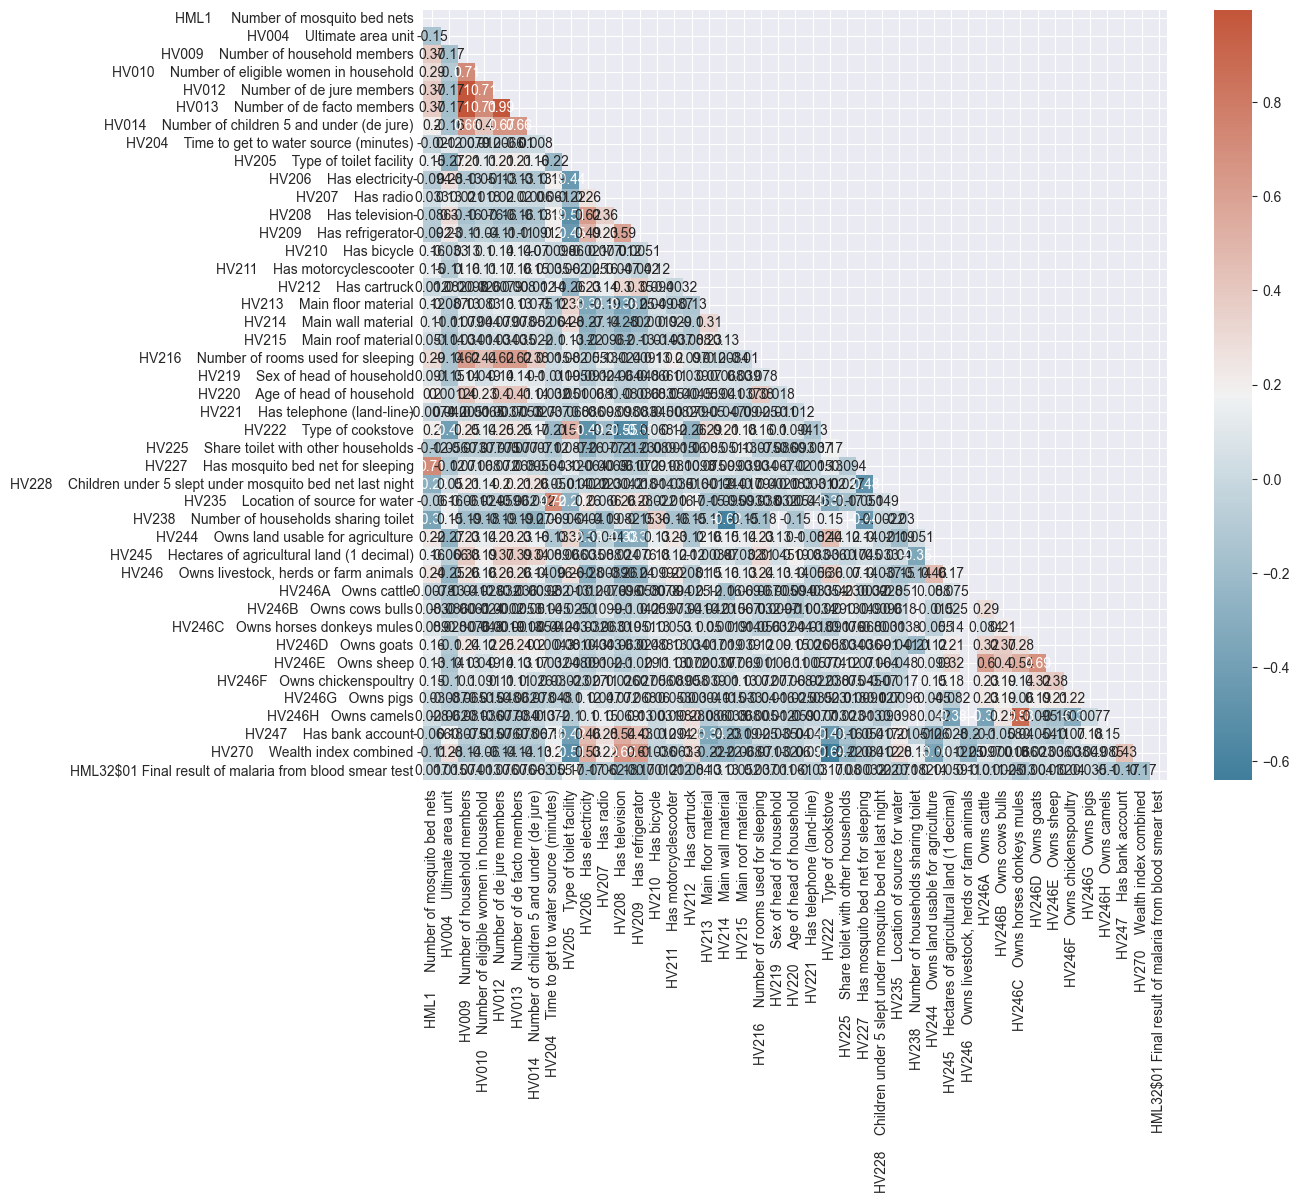

In [62]:
corr = demo_socio_data.corr()
f, ax = plt.subplots(figsize=(12, 10))
mask = np.triu(np.ones_like(corr, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, annot=True, mask = mask, cmap=cmap)

<Axes: >

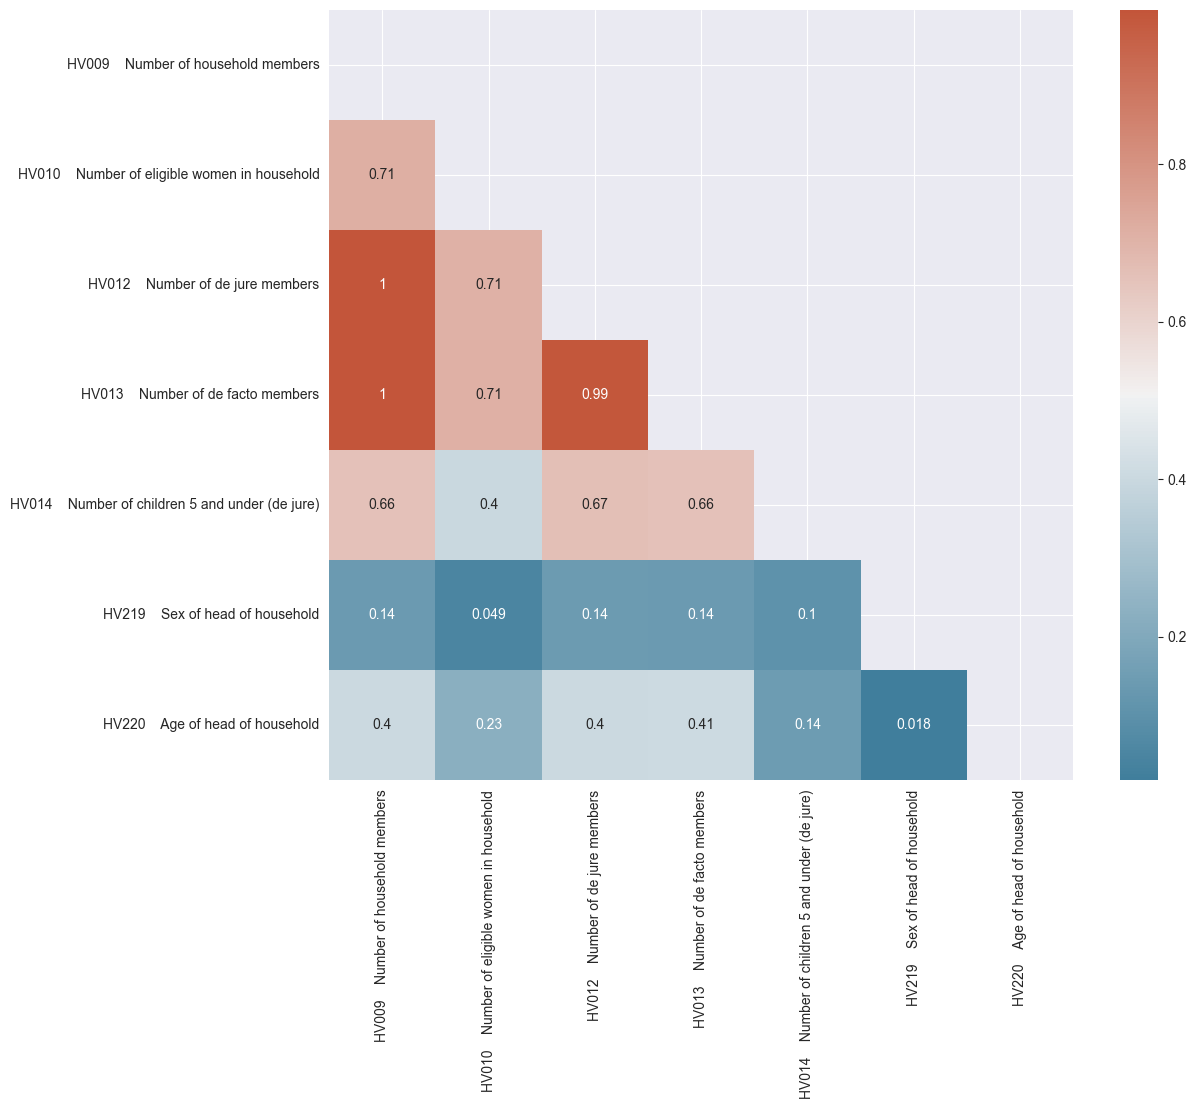

In [63]:
corr = demo_socio_data[demographic_factors].corr()
f, ax = plt.subplots(figsize=(12, 10))
mask = np.triu(np.ones_like(corr, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, annot=True, mask = mask, cmap=cmap)

<Axes: >

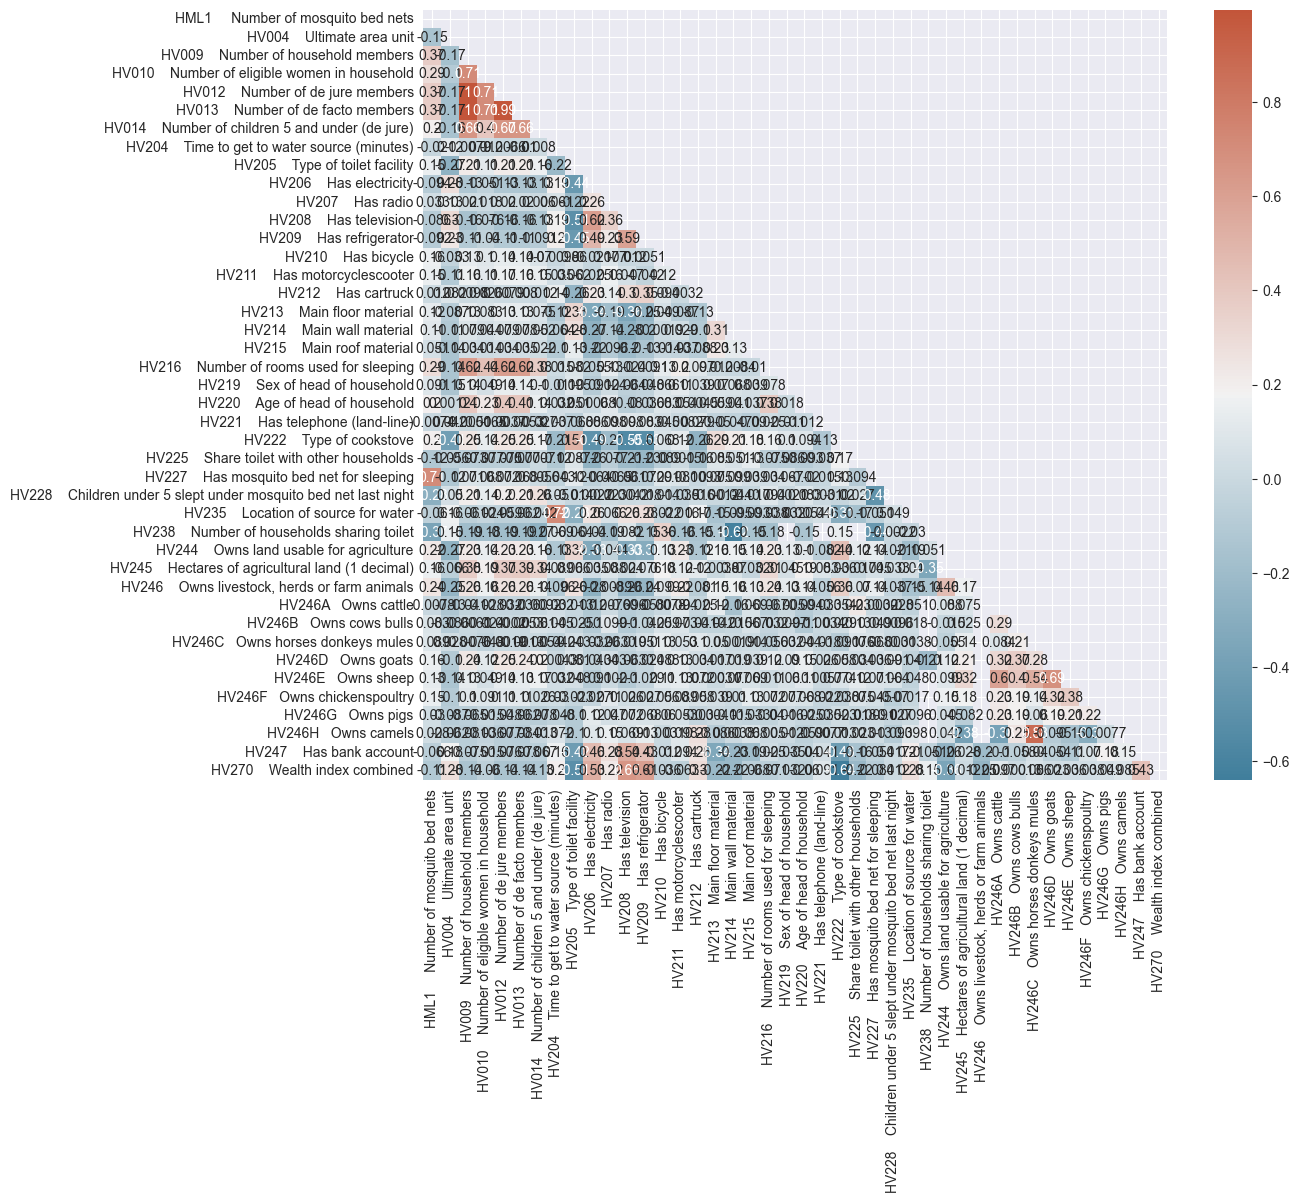

In [64]:
corr = demo_socio_data[socio_economic_factors].corr()
f, ax = plt.subplots(figsize=(12, 10))
mask = np.triu(np.ones_like(corr, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, annot=True, mask = mask, cmap=cmap)

In [65]:
demo_socio_data = demo_socio_data.fillna(demo_socio_data.mean())
demo_socio_data.isnull().sum()

HML1     Number of mosquito bed nets                                 0
HV004    Ultimate area unit                                          0
HV009    Number of household members                                 0
HV010    Number of eligible women in household                       0
HV012    Number of de jure members                                   0
HV013    Number of de facto members                                  0
HV014    Number of children 5 and under (de jure)                    0
HV204    Time to get to water source (minutes)                       0
HV205    Type of toilet facility                                     0
HV206    Has electricity                                             0
HV207    Has radio                                                   0
HV208    Has television                                              0
HV209    Has refrigerator                                            0
HV210    Has bicycle                                                 0
HV211 

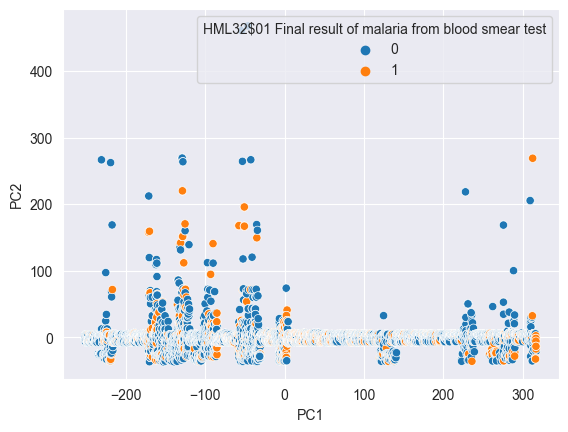

In [66]:

# Due to the large number of columns, exploratory data analysis is not easy. PCA is used to reduce the number of columns. inorder to perform EDA, the data is reduced to 2 dimensions using PCA.

# Split the data into features and labels
X = demo_socio_data.drop([target], axis=1)
y = demo_socio_data[target]

# Instantiate a PCA object and fit it to the data
pca = PCA(n_components=2)
pca.fit(X)

# Transform the data into 2D using the PCA object
X_2d = pca.transform(X)

# Plot the transformed data
# plt.scatter(X_2d[:, 0], X_2d[:, 1], c=y)

sns.scatterplot(x=X_2d[:, 0], y=X_2d[:, 1], hue=y)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

In [67]:
new_data = demo_socio_data.__deepcopy__()
Y_data = new_data.pop(target)
X_data = new_data

Class Labels Index([0, 1], dtype='int64', name='HML32$01 Final result of malaria from blood smear test')
Class Counts [8390 2265]
Class Percentage [78.74237447 21.25762553]


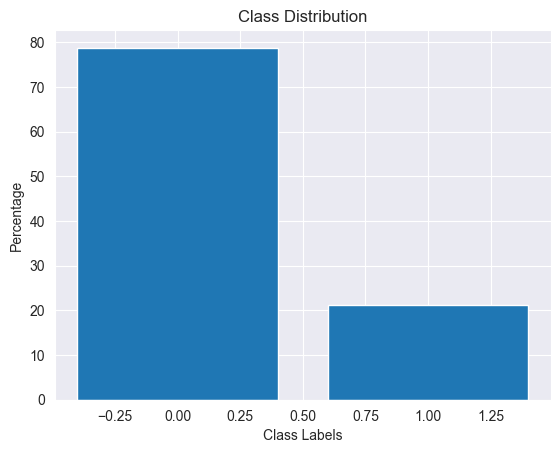

In [68]:
# Assuming your target variable is stored in a column called 'target'
target_counts = Y_data.value_counts()

# Calculate the class distribution
class_labels = target_counts.index
class_counts = target_counts.values
total_samples = len(new_data)

# Calculate the percentage of each class
class_percentages = (class_counts / total_samples) * 100
print('Class Labels', class_labels)
print('Class Counts', class_counts)
print('Class Percentage', class_percentages)

# Plotting the class distribution
plt.bar(class_labels, class_percentages)
plt.xlabel('Class Labels')
plt.ylabel('Percentage')
plt.title('Class Distribution')
plt.show()

In [69]:
def undersampling():
    # Perform undersampling
    undersampler = RandomUnderSampler(sampling_strategy='majority')
    return undersampler.fit_resample(X_data, Y_data)


def oversampling():
    # Perform oversampling
    oversampler = RandomOverSampler(sampling_strategy='minority')
    return oversampler.fit_resample(X_data, Y_data)


def smote():
    # Perform SMOTE
    smote_sampler = SMOTE(sampling_strategy='minority')
    return smote_sampler.fit_resample(X_data, Y_data)


classifier = LogisticRegression()
results = {}
for algorithm in [undersampling, oversampling, smote]:
    X, Y = algorithm()
    classifier.fit(X, Y)
    predicted_labels = classifier.predict(X_data)
    accuracy = accuracy_score(Y_data, predicted_labels)
    results[algorithm.__name__] = accuracy

# Determine the best algorithm based on the accuracy
best_algorithm = max(results, key=results.get)

# Print the results and the best algorithm
print("Sampling Algorithm Results:")
for algorithm, accuracy in results.items():
    print(f"{algorithm}: {accuracy}")
print("\nBest Algorithm:")
print(best_algorithm)

/Library/Python/3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Python/3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimiz

Sampling Algorithm Results:
undersampling: 0.5841389019239793
oversampling: 0.5740028155795401
smote: 0.6385734396996715

Best Algorithm:
smote


/Library/Python/3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [70]:
X_data.columns

Index(['HML1     Number of mosquito bed nets', 'HV004    Ultimate area unit',
       'HV009    Number of household members',
       'HV010    Number of eligible women in household',
       'HV012    Number of de jure members',
       'HV013    Number of de facto members',
       'HV014    Number of children 5 and under (de jure)',
       'HV204    Time to get to water source (minutes)',
       'HV205    Type of toilet facility', 'HV206    Has electricity',
       'HV207    Has radio', 'HV208    Has television',
       'HV209    Has refrigerator', 'HV210    Has bicycle',
       'HV211    Has motorcyclescooter', 'HV212    Has cartruck',
       'HV213    Main floor material', 'HV214    Main wall material',
       'HV215    Main roof material',
       'HV216    Number of rooms used for sleeping',
       'HV219    Sex of head of household',
       'HV220    Age of head of household',
       'HV221    Has telephone (land-line)', 'HV222    Type of cookstove',
       'HV225    Share toilet wit

In [71]:
!pip install boruta

In [72]:
# 


In [73]:
# feature_selection(X_data, Y_data)

In [74]:
# br = BoostARoota(metric='logloss', iters=2)
# br.fit(X_data, Y_data)
# print('The number of features that are not correlated: ', br.transform(X_data).shape[1])
# print('The number of features that are correlated: ', X_data.shape[1] - br.transform(X_data).shape[1])
# print('The percentage of features that are not correlated: ', br.transform(X_data).shape[1] / X_data.shape[1])
# print('The percentage of features that are correlated: ', 1 - br.transform(X_data).shape[1] / X_data.shape[1])
# print('The features that are important: ', br.keep_vars_)

In [75]:
# X_data = feature_selection(X_data,Y_data).transform(X_data)
# # X_data = br.transform(X_data)
X_train, X_test, y_train, y_test = train_test_split(X_data, Y_data, test_size=0.2, random_state=42)

In [76]:
class func():
    def __init__(self, train, label, test, model, model_type, random_state):
        self.train, self.label, self.test = train, label, test
        self.model, self.model_type = model, model_type
        self.random_state = random_state

        assert self.model_type in ('catboost', 'xgboost', 'lgbm', 'log'), 'Incorrect model_type'

    def __call__(self, plot=True):
        return self.fit(plot)

    def fit(self, plot):
        def log_fit(X_train, X_test, y_train, y_test):
            self.model.fit(X_train, y_train)
            x_test_predict = self.model.predict_proba(X_test)[:, 1]
            x_train_predict = self.model.predict_proba(X_train)[:, 1]
            self.val_p[test_index] = x_test_predict
            self.test_p += self.model.predict_proba(self.test)[:, 1]
            return x_test_predict, x_train_predict

        def catboost_fit(X_train, X_test, y_train, y_test):
            self.model.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=500,
                           verbose=50, use_best_model=True)
            x_test_predict = self.model.predict_proba(X_test)[:, 1]
            x_train_predict = self.model.predict_proba(X_train)[:, 1]
            self.val_p[test_index] = x_test_predict
            self.test_p += self.model.predict_proba(self.test)[:, 1]
            return x_test_predict, x_train_predict

        def xgboost_fit(X_train, X_test, y_train, y_test):
            self.model.fit(X_train, y_train, early_stopping_rounds=30, eval_metric="auc",
                           eval_set=[(X_test, y_test)], verbose=True)
            x_test_predict = self.model.predict_proba(X_test, ntree_limit=self.model.get_booster().best_ntree_limit)[:,
                             1]
            x_train_predict = self.model.predict_proba(X_train, ntree_limit=self.model.get_booster().best_ntree_limit)[
                              :, 1]
            self.val_p[test_index] = x_test_predict
            self.test_p += self.model.predict_proba(self.test, ntree_limit=self.model.get_booster().best_ntree_limit)[:,
                           1]
            return x_test_predict, x_train_predict

        def lgbm_fit(X_train, X_test, y_train, y_test):
            self.model.fit(X_train, y_train, early_stopping_rounds=30, eval_metric="auc",
                           eval_set=[(X_test, y_test)], verbose=True)
            x_test_predict = self.model.predict_proba(X_test, num_iteration=self.model.best_iteration_)[:, 1]
            x_train_predict = self.model.predict_proba(X_train, num_iteration=self.model.best_iteration_)[:, 1]
            self.val_p[test_index] = x_test_predict
            self.test_p += self.model.predict_proba(self.test, num_iteration=self.model.best_iteration_)[:, 1]
            return x_test_predict, x_train_predict

        self.val_p = np.zeros(self.train.shape[0])
        mean_val = []
        mean_train = []
        self.test_p = np.zeros(self.test.shape[0])
        splits = 5
        kf = StratifiedKFold(n_splits=splits)
        for fold_count, (train_index, test_index) in enumerate(kf.split(self.train, self.label)):
            X_train, X_test = self.train.iloc[train_index], self.train.iloc[test_index]
            y_train, y_test = self.label.iloc[train_index], self.label.iloc[test_index]

            print(f"================================Fold{fold_count + 1}====================================")
            if self.model_type == 'catboost':
                x_test_predict, x_train_predict = catboost_fit(X_train, X_test, y_train, y_test)
            elif self.model_type == 'xgboost':
                x_test_predict, x_train_predict = xgboost_fit(X_train, X_test, y_train, y_test)
            elif self.model_type == 'log':
                x_test_predict, x_train_predict = log_fit(X_train, X_test, y_train, y_test)
            elif self.model_type == 'lgbm':
                x_test_predict, x_train_predict = lgbm_fit(X_train, X_test, y_train, y_test)
            print('\nValidation scores', roc_auc_score(y_test, x_test_predict), log_loss(y_test, x_test_predict))
            print('Training scores', roc_auc_score(y_train, x_train_predict), log_loss(y_train, x_train_predict))
            mean_val.append(roc_auc_score(y_train, x_train_predict))
            mean_train.append(roc_auc_score(y_train, x_train_predict))

        if plot and self.model_type != 'log':
            feat_imp = pd.DataFrame(sorted(zip(self.model.feature_importances_, self.train.columns)),
                                    columns=['Value', 'Feature'])
            plt.figure(figsize=(30, 25))
            sns.barplot(x="Value", y="Feature", data=feat_imp.sort_values(by="Value", ascending=False))
            plt.ylabel('Feature Importance Score')
            plt.show()
        print(np.mean(mean_val), np.mean(mean_train), np.std(mean_val))
        return self.val_p, self.test_p / splits, self.model

In [77]:
func_ = func(X_train, y_train, X_test, classifier, 'log', 1000)
val_p, test_p, model = func_()

================================Fold1====================================

Validation scores 0.6912138742737451 0.47428902513405063
Training scores 0.6973970909083351 0.47235763179585155
================================Fold2====================================


/Library/Python/3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Python/3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimiz


Validation scores 0.6712777098970151 0.4832938435189823
Training scores 0.6905315270237199 0.4755574735096701
================================Fold3====================================

Validation scores 0.6725432012567638 0.48151430093970293
Training scores 0.682759989545809 0.4779190267010889
================================Fold4====================================

Validation scores 0.6939516162548105 0.47316502499151564
Training scores 0.6840542282578028 0.4783137877053701
================================Fold5====================================

Validation scores 0.6651673289954437 0.4954364737428303
Training scores 0.6966038362674446 0.4732716196835418
0.6902693344006223 0.6902693344006223 0.0060994651604980655


/Library/Python/3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


================================Fold1====================================
0:	learn: 0.6984739	test: 0.6981658	best: 0.6981658 (0)	total: 62.4ms	remaining: 10m 24s
50:	learn: 0.6981236	test: 0.6981658	best: 0.6981658 (0)	total: 249ms	remaining: 48.6s
100:	learn: 0.6981236	test: 0.6981658	best: 0.6981658 (0)	total: 366ms	remaining: 35.9s
150:	learn: 0.7021511	test: 0.6992717	best: 0.6995643 (141)	total: 483ms	remaining: 31.5s
200:	learn: 0.7057270	test: 0.6991790	best: 0.7006606 (152)	total: 600ms	remaining: 29.2s
250:	learn: 0.7109487	test: 0.7083038	best: 0.7086216 (242)	total: 714ms	remaining: 27.7s
300:	learn: 0.7121231	test: 0.7096264	best: 0.7096264 (298)	total: 829ms	remaining: 26.7s
350:	learn: 0.7146708	test: 0.7109434	best: 0.7109434 (326)	total: 954ms	remaining: 26.2s
400:	learn: 0.7180800	test: 0.7106198	best: 0.7109434 (326)	total: 1.08s	remaining: 25.8s
450:	learn: 0.7206534	test: 0.7119284	best: 0.7119284 (404)	total: 1.2s	remaining: 25.4s
500:	learn: 0.7228007	test: 0.713

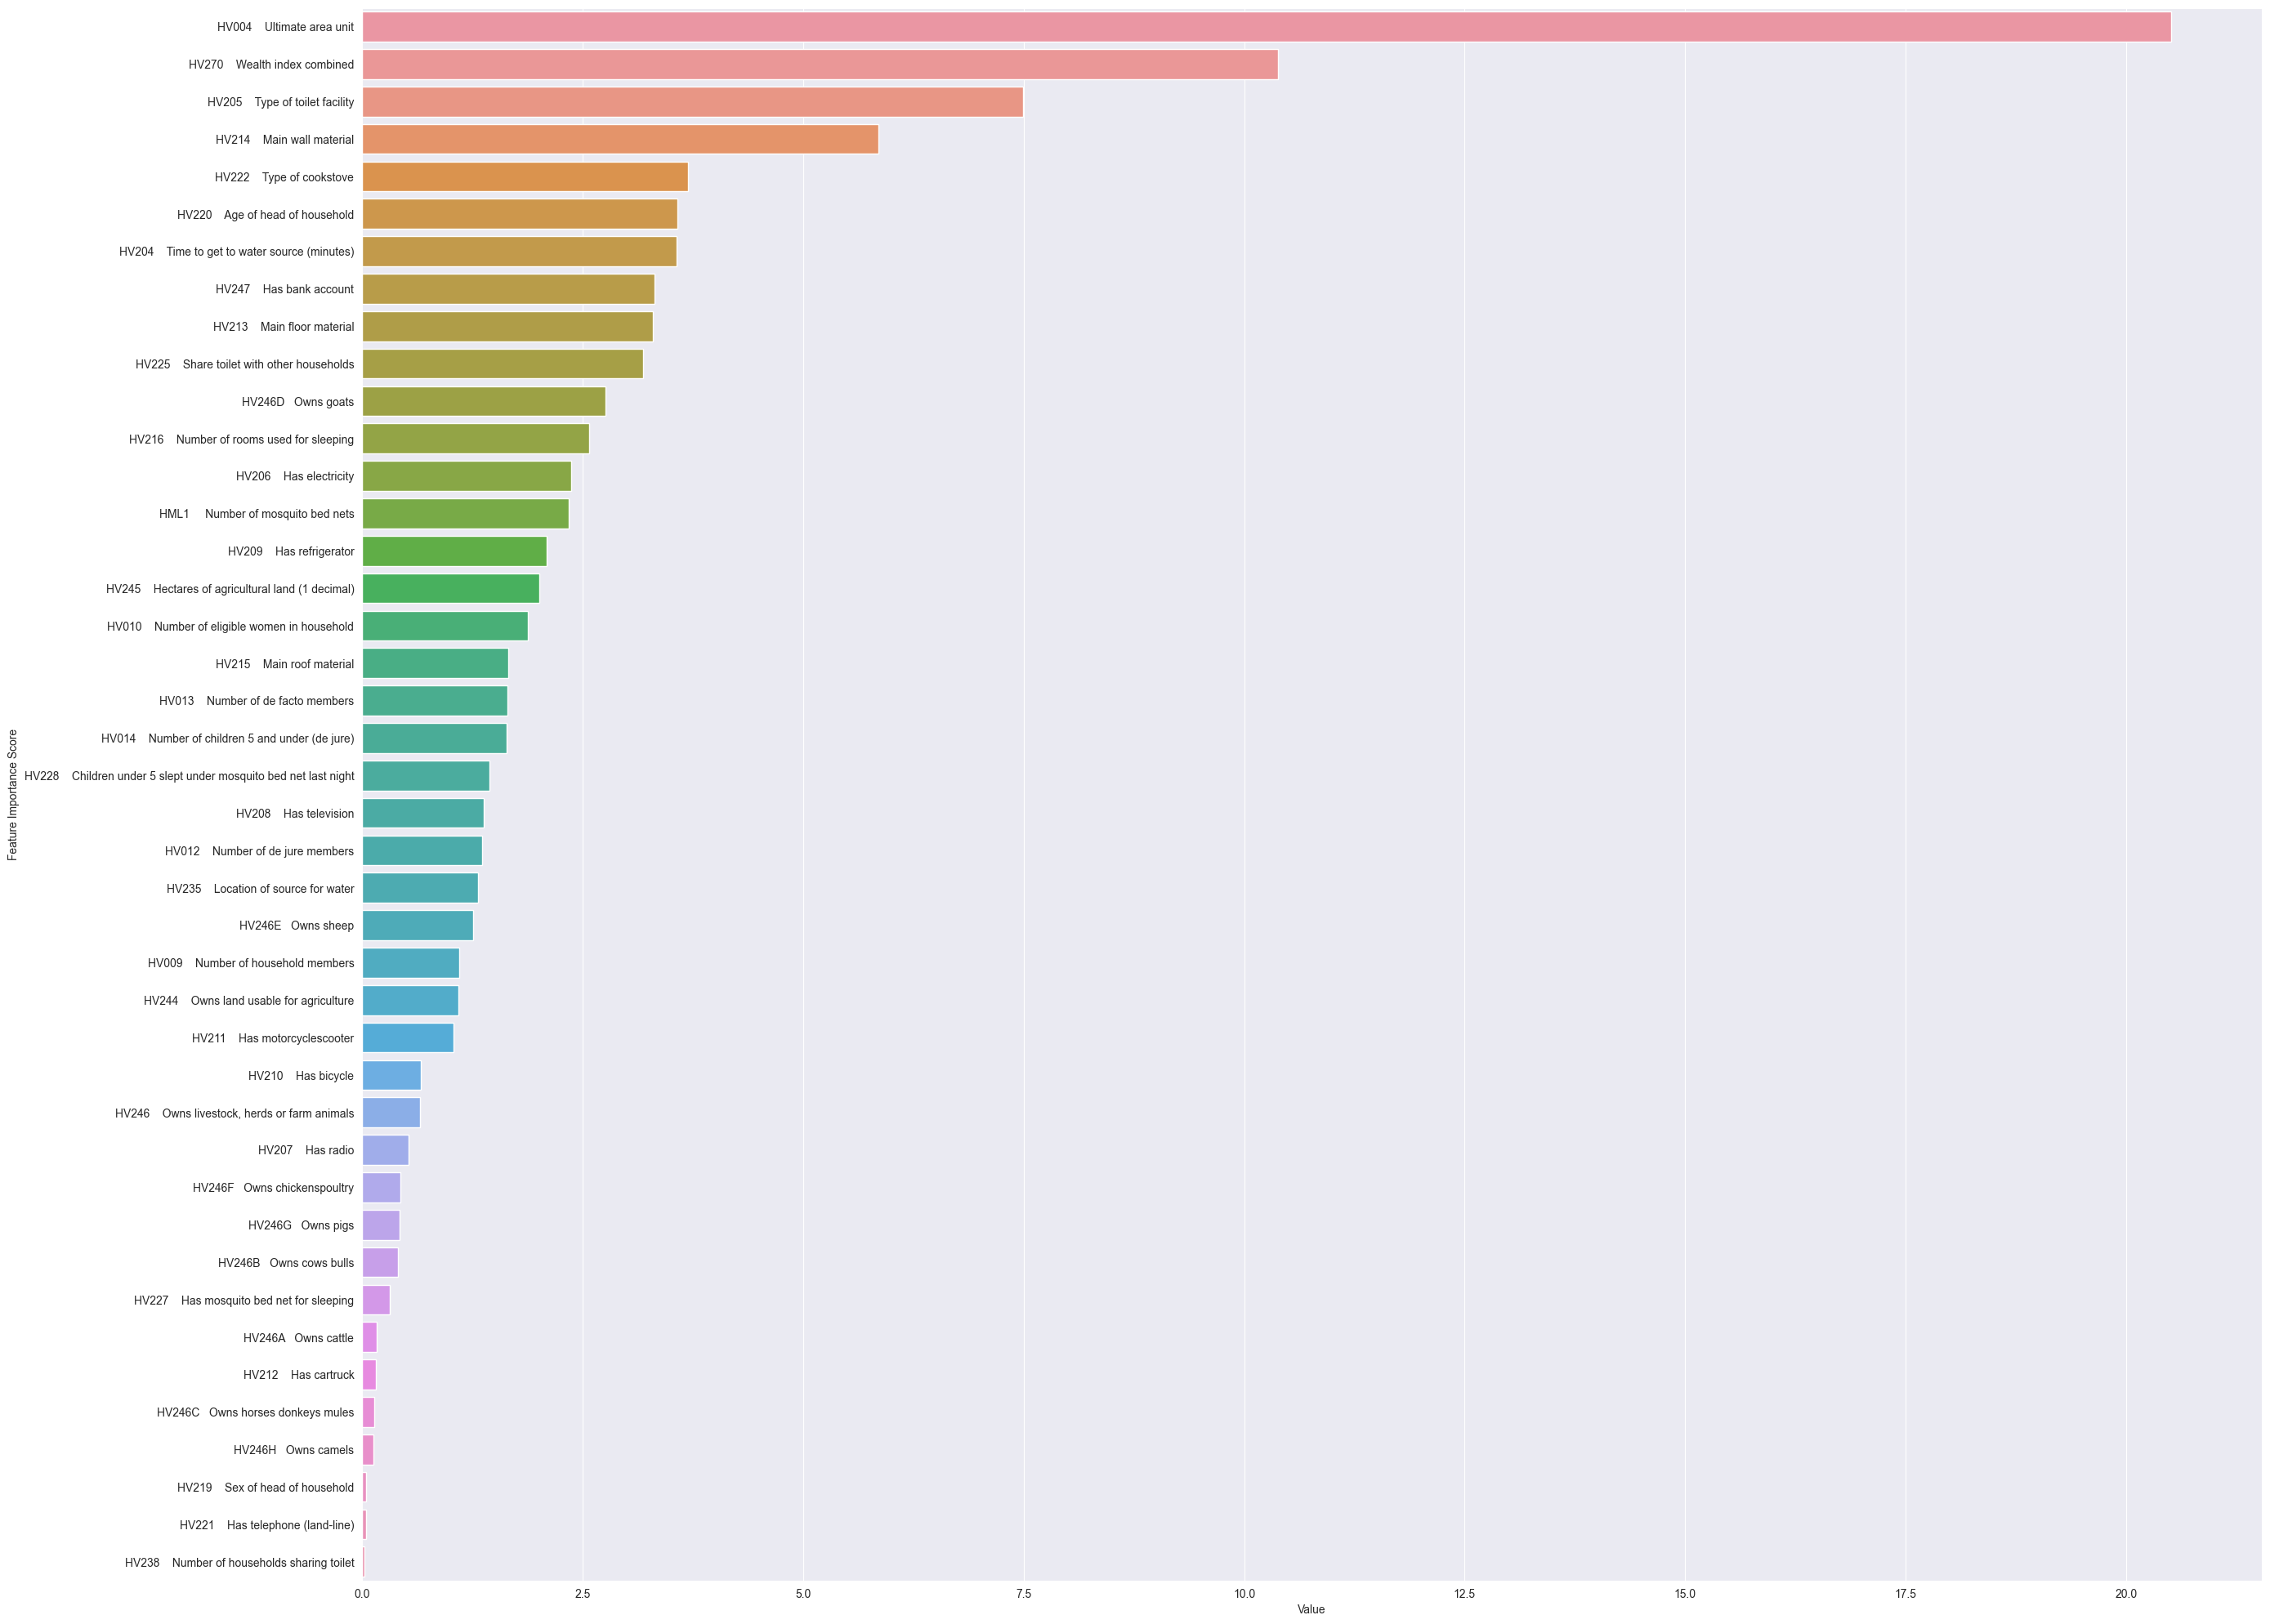

0.8357933882064843 0.8357933882064843 0.02580356187729592


In [78]:
catboost = cat_.CatBoostClassifier(n_estimators=10000, max_depth=6, eval_metric='TotalF1', reg_lambda=370)

func_ = func(X_train, y_train, X_test, catboost, 'catboost', 1000)
val_p1, test_p1, model1 = func_()

================================Fold1====================================
[19:05:57] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "objectsve", "scoring", "sub_sample" } are not used.

[0]	validation_0-auc:0.51030
[1]	validation_0-auc:0.62614
[2]	validation_0-auc:0.68563
[3]	validation_0-auc:0.70028
[4]	validation_0-auc:0.71568
[5]	validation_0-auc:0.72143
[6]	validation_0-auc:0.72392
[7]	validation_0-auc:0.72499
[8]	validation_0-auc:0.72466
[9]	validation_0-auc:0.72727
[10]	validation_0-auc:0.72716
[11]	validation_0-auc:0.72918
[12]	validation_0-auc:0.73021
[13]	validation_0-auc:0.73101
[14]	validation_0-auc:0.73229
[15]	validation_0-auc:0.73187
[16]	validation_0-auc:0.73161
[17]	validation_0-auc:0.73218
[18]	validation_0-auc:0.73128
[19]	validation_0-auc:0.73262
[20]	validation_0-auc:0.73225
[21]	validation_0-auc:0.73361
[22]	validation_0-auc:0.73343
[23]	validation_0-auc:0.73429
[24]	vali

/Library/Python/3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Library/Python/3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[33]	validation_0-auc:0.73550
[34]	validation_0-auc:0.73667
[35]	validation_0-auc:0.73628
[36]	validation_0-auc:0.73550
[37]	validation_0-auc:0.73517
[38]	validation_0-auc:0.73514
[39]	validation_0-auc:0.73513
[40]	validation_0-auc:0.73537
[41]	validation_0-auc:0.73666
[42]	validation_0-auc:0.73639
[43]	validation_0-auc:0.73661
[44]	validation_0-auc:0.73650
[45]	validation_0-auc:0.73656
[46]	validation_0-auc:0.73655
[47]	validation_0-auc:0.73809
[48]	validation_0-auc:0.73746
[49]	validation_0-auc:0.73777
[50]	validation_0-auc:0.73772
[51]	validation_0-auc:0.73867
[52]	validation_0-auc:0.73880
[53]	validation_0-auc:0.73890
[54]	validation_0-auc:0.73974
[55]	validation_0-auc:0.73938
[56]	validation_0-auc:0.73910
[57]	validation_0-auc:0.73975
[58]	validation_0-auc:0.74126
[59]	validation_0-auc:0.74150
[60]	validation_0-auc:0.74195
[61]	validation_0-auc:0.74245
[62]	validation_0-auc:0.74183
[63]	validation_0-auc:0.74147
[64]	validation_0-auc:0.74137
[65]	validation_0-auc:0.74174
[66]	valid

/Library/Python/3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/Library/Python/3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/Library/Python/3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/Library/Python/3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Library/Python/3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[48]	validation_0-auc:0.71812
[49]	validation_0-auc:0.71807
[50]	validation_0-auc:0.71863
[51]	validation_0-auc:0.71881
[52]	validation_0-auc:0.72021
[53]	validation_0-auc:0.72099
[54]	validation_0-auc:0.71990
[55]	validation_0-auc:0.72053
[56]	validation_0-auc:0.72060
[57]	validation_0-auc:0.72059
[58]	validation_0-auc:0.72060
[59]	validation_0-auc:0.72084
[60]	validation_0-auc:0.72053
[61]	validation_0-auc:0.72122
[62]	validation_0-auc:0.72060
[63]	validation_0-auc:0.72092
[64]	validation_0-auc:0.72096
[65]	validation_0-auc:0.72074
[66]	validation_0-auc:0.72091
[67]	validation_0-auc:0.72213
[68]	validation_0-auc:0.72173
[69]	validation_0-auc:0.72227
[70]	validation_0-auc:0.72225
[71]	validation_0-auc:0.72224
[72]	validation_0-auc:0.72227
[73]	validation_0-auc:0.72207
[74]	validation_0-auc:0.72119
[75]	validation_0-auc:0.72123
[76]	validation_0-auc:0.72125
[77]	validation_0-auc:0.72079
[78]	validation_0-auc:0.72031
[79]	validation_0-auc:0.71960
[80]	validation_0-auc:0.72012
[81]	valid

/Library/Python/3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/Library/Python/3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/Library/Python/3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/Library/Python/3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Library/Python/3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[49]	validation_0-auc:0.73275
[50]	validation_0-auc:0.73343
[51]	validation_0-auc:0.73398
[52]	validation_0-auc:0.73495
[53]	validation_0-auc:0.73320
[54]	validation_0-auc:0.73281
[55]	validation_0-auc:0.73278
[56]	validation_0-auc:0.73205
[57]	validation_0-auc:0.73253
[58]	validation_0-auc:0.73339
[59]	validation_0-auc:0.73291
[60]	validation_0-auc:0.73194
[61]	validation_0-auc:0.73286
[62]	validation_0-auc:0.73379
[63]	validation_0-auc:0.73331
[64]	validation_0-auc:0.73359
[65]	validation_0-auc:0.73328
[66]	validation_0-auc:0.73304
[67]	validation_0-auc:0.73267
[68]	validation_0-auc:0.73382
[69]	validation_0-auc:0.73303
[70]	validation_0-auc:0.73421
[71]	validation_0-auc:0.73318
[72]	validation_0-auc:0.73340
[73]	validation_0-auc:0.73290
[74]	validation_0-auc:0.73348
[75]	validation_0-auc:0.73415
[76]	validation_0-auc:0.73454
[77]	validation_0-auc:0.73382
[78]	validation_0-auc:0.73378
[79]	validation_0-auc:0.73399
[80]	validation_0-auc:0.73355
[81]	validation_0-auc:0.73275

Validatio

/Library/Python/3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/Library/Python/3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/Library/Python/3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/Library/Python/3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Library/Python/3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[46]	validation_0-auc:0.73362
[47]	validation_0-auc:0.73271
[48]	validation_0-auc:0.73399
[49]	validation_0-auc:0.73457
[50]	validation_0-auc:0.73410
[51]	validation_0-auc:0.73441
[52]	validation_0-auc:0.73399
[53]	validation_0-auc:0.73442
[54]	validation_0-auc:0.73407
[55]	validation_0-auc:0.73456
[56]	validation_0-auc:0.73489
[57]	validation_0-auc:0.73580
[58]	validation_0-auc:0.73507
[59]	validation_0-auc:0.73448
[60]	validation_0-auc:0.73474
[61]	validation_0-auc:0.73490
[62]	validation_0-auc:0.73517
[63]	validation_0-auc:0.73523
[64]	validation_0-auc:0.73564

Validation scores 0.7358146522704037 0.4540182450156914
Training scores 0.818472028024714 0.40550561284250297
================================Fold5====================================
[19:05:58] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "objectsve", "scoring", "sub_sample" } are not used.

[0]	validation_0-auc:0.51389
[1]	valid

/Library/Python/3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/Library/Python/3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/Library/Python/3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/Library/Python/3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Library/Python/3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[45]	validation_0-auc:0.71919
[46]	validation_0-auc:0.71970
[47]	validation_0-auc:0.71935
[48]	validation_0-auc:0.71993
[49]	validation_0-auc:0.72027
[50]	validation_0-auc:0.72077
[51]	validation_0-auc:0.71982
[52]	validation_0-auc:0.71929
[53]	validation_0-auc:0.71890
[54]	validation_0-auc:0.71862
[55]	validation_0-auc:0.71961
[56]	validation_0-auc:0.72019
[57]	validation_0-auc:0.71970
[58]	validation_0-auc:0.71993
[59]	validation_0-auc:0.72014
[60]	validation_0-auc:0.71981
[61]	validation_0-auc:0.71984
[62]	validation_0-auc:0.72132
[63]	validation_0-auc:0.72126
[64]	validation_0-auc:0.72130
[65]	validation_0-auc:0.72130
[66]	validation_0-auc:0.72271
[67]	validation_0-auc:0.72274
[68]	validation_0-auc:0.72324
[69]	validation_0-auc:0.72320
[70]	validation_0-auc:0.72318
[71]	validation_0-auc:0.72272
[72]	validation_0-auc:0.72266
[73]	validation_0-auc:0.72135
[74]	validation_0-auc:0.72182
[75]	validation_0-auc:0.72265
[76]	validation_0-auc:0.72174
[77]	validation_0-auc:0.72182
[78]	valid

/Library/Python/3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/Library/Python/3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/Library/Python/3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


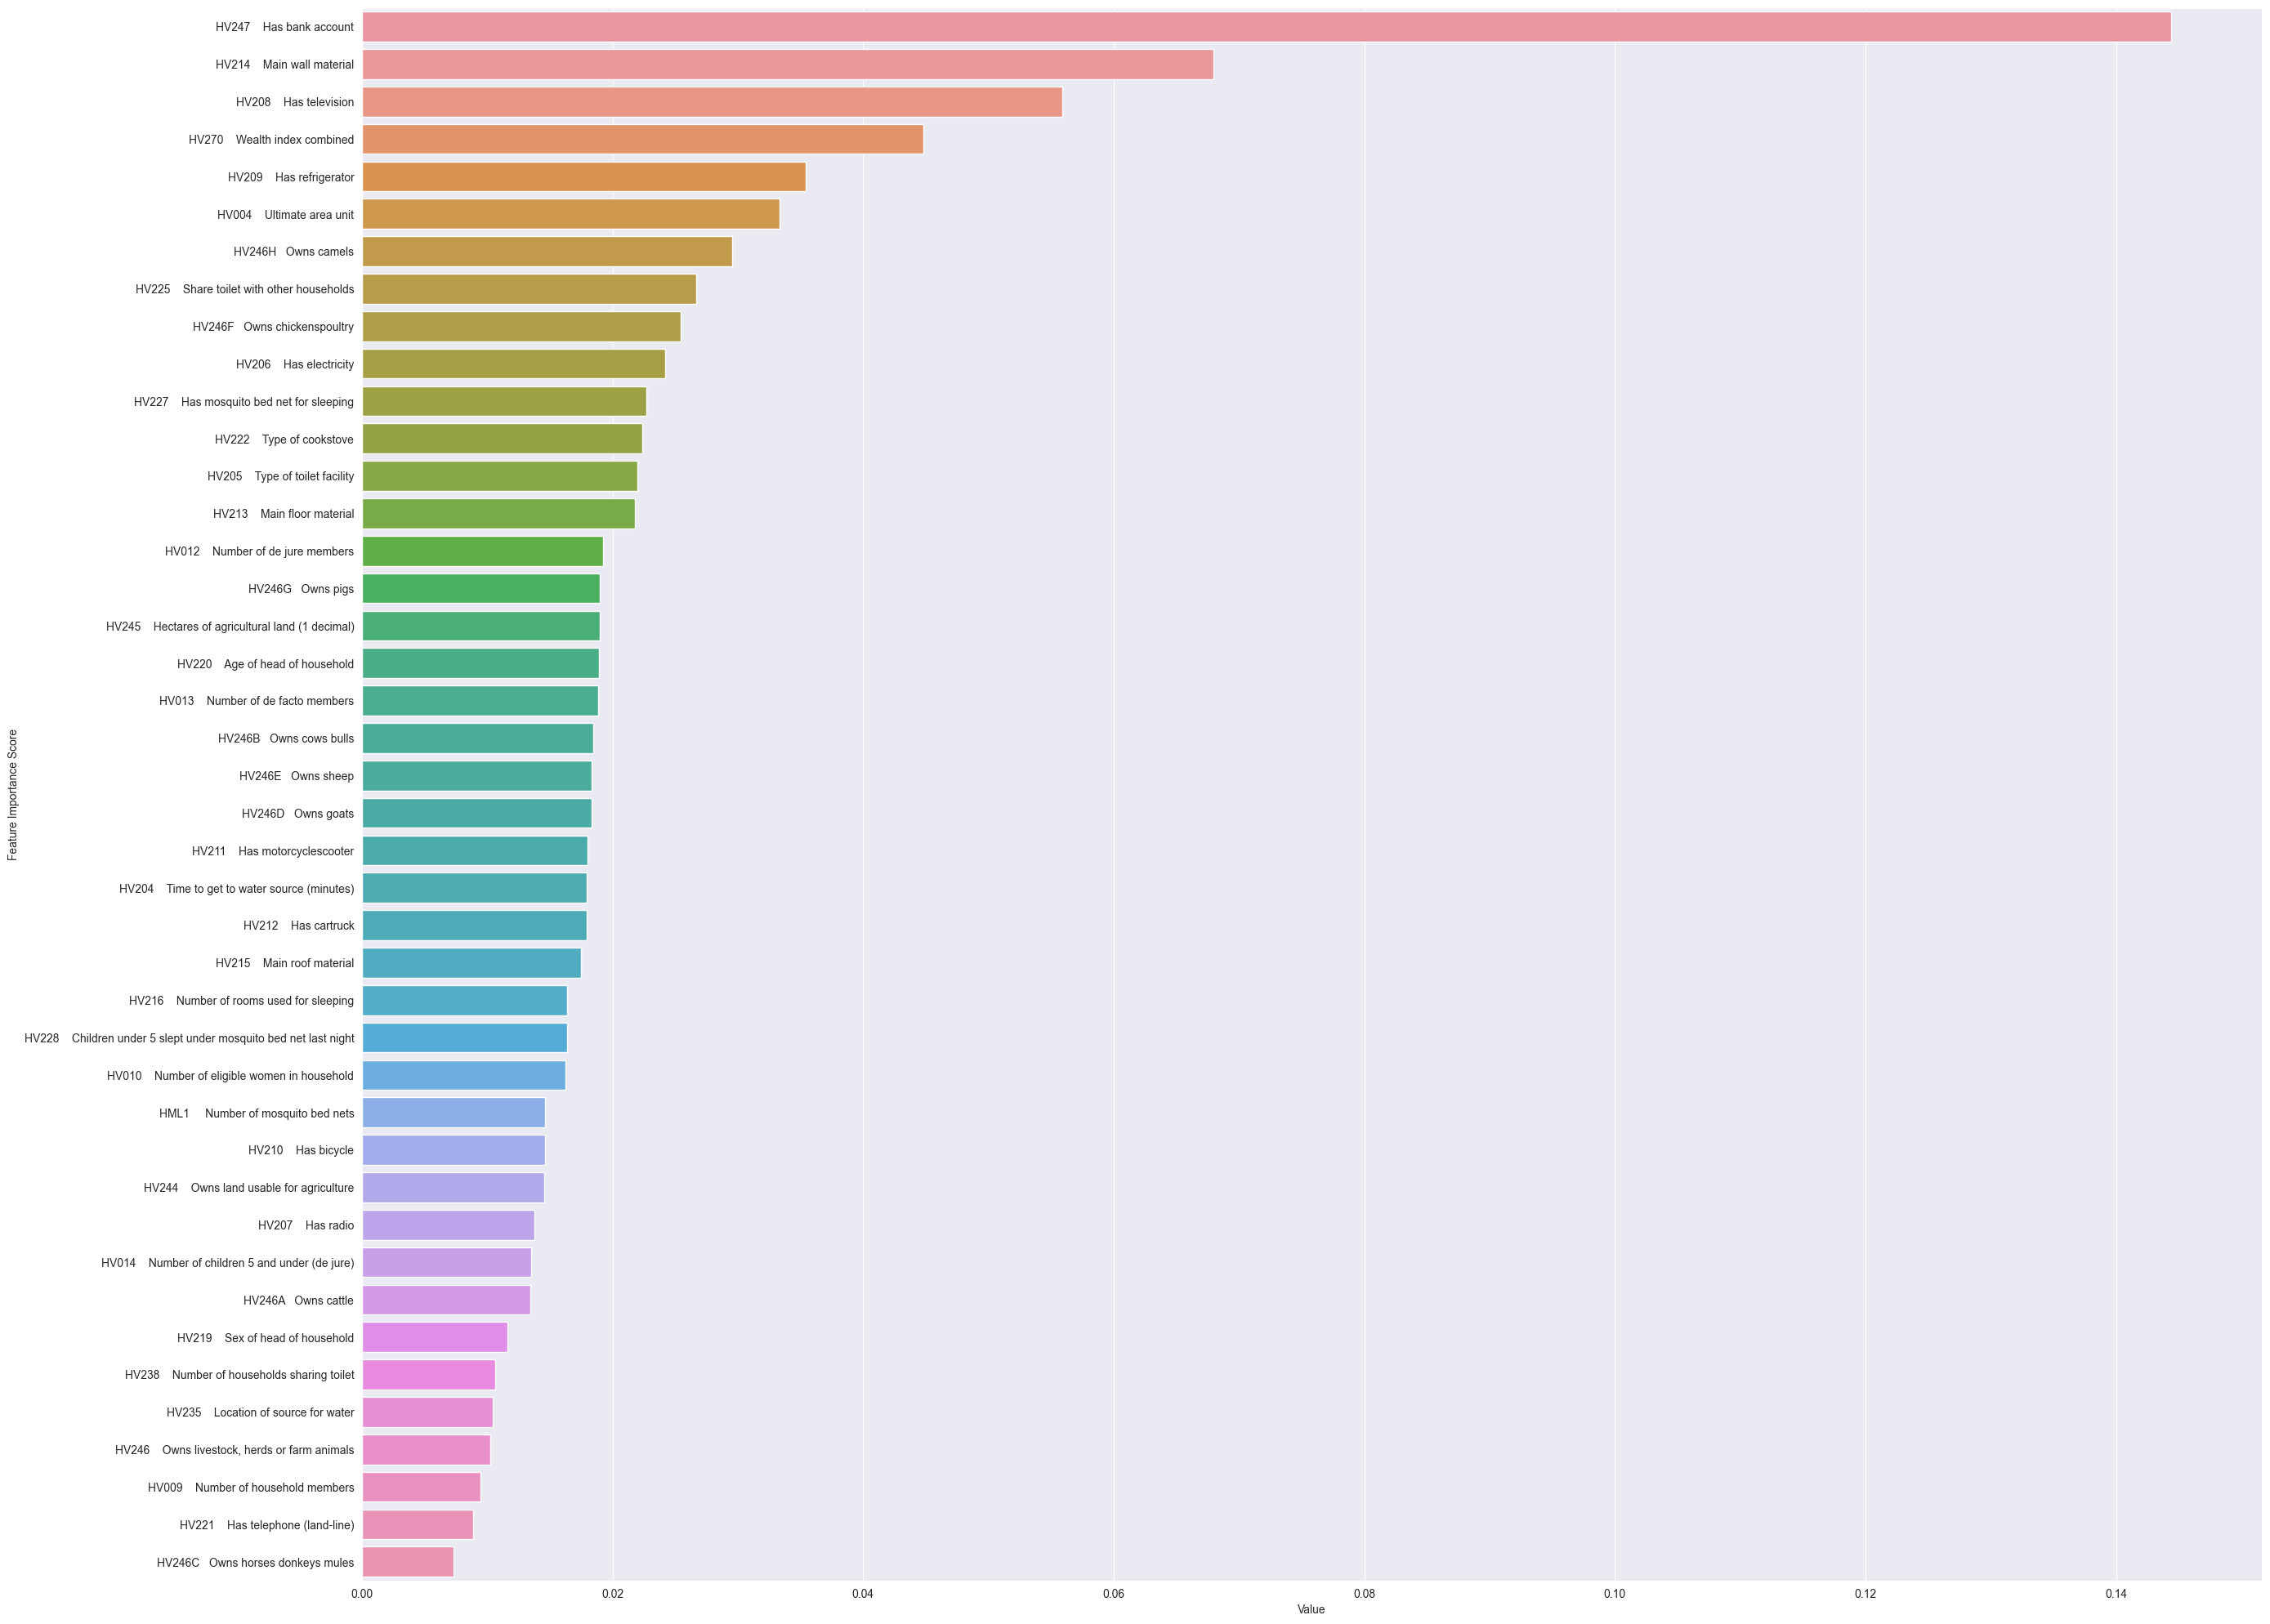

0.8477859781473847 0.8477859781473847 0.016718926975866973


In [79]:
xgboost = xgb.XGBClassifier(objectsve='binary:logistic',
                            eta=0.99,
                            max_depth=6,
                            n_estimators=5000,
                            reg_lambda=500,
                            scoring='f1',
                            sub_sample=0.8,
                            colsample_bytree=0.8)

func_ = func(X_train, y_train, X_test, xgboost, 'xgboost', 1000)
val_p2, test_p2, model2 = func_()

In [80]:
from subprocess import check_output
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D,Dense,Flatten,Dropout
from keras.optimizers import Adam
from keras.callbacks import TensorBoard
num_classes = 10
epochs = 20

In [81]:
X_train.shape

(8524, 42)

In [82]:
data_rows = X_train.shape[0]
data_cols = X_train.shape[1]
batch_size = 4096
data_shape = (data_rows,data_cols,1) 

In [83]:
data_shape

(8524, 42, 1)

In [84]:
NN_model = Sequential()

# The Input Layer :
NN_model.add(Dense(324, kernel_initializer='normal',input_dim = X_train.shape[1], activation='relu'))

# The Hidden Layers :
NN_model.add(Dense(512, activation='relu'))
NN_model.add(Dense(1024, activation='relu'))
NN_model.add(Dense(1024, activation='relu'))
NN_model.add(Dense(512, activation='relu'))
NN_model.add(Dense(256, activation='relu'))


NN_model.add(Flatten())


NN_model.add(Dense(4096, activation='relu'))
NN_model.add(Dropout(0.5))

NN_model.add(Dense(4096, activation='relu'))
NN_model.add(Dropout(0.5))

# The Output Layer :
NN_model.add(Dense(2, kernel_initializer='normal',activation='relu', kernel_regularizer = tf.keras.regularizers.l1(l=0.01) ))
# NN_model.add(Dense(1, kernel_initializer='normal',activation='linear', kernel_regularizer = tf.keras.regularizers.l1(l=0.01) ))

optimizer=Adam(learning_rate=0.01, beta_1=0.9, beta_2=0.999)

# Compile the network :
NN_model.compile(optimizer=optimizer, loss='mean_absolute_error', metrics=['mean_absolute_error', 'accuracy'])
# NN_model.compile(optimizer=optimizer, loss='mean_absolute_error', metrics=['mean_absolute_error'])
NN_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 324)               13932     
                                                                 
 dense_1 (Dense)             (None, 512)               166400    
                                                                 
 dense_2 (Dense)             (None, 1024)              525312    
                                                                 
 dense_3 (Dense)             (None, 1024)              1049600   
                                                                 
 dense_4 (Dense)             (None, 512)               524800    
                                                                 
 dense_5 (Dense)             (None, 256)               131328    
                                                                 
 flatten (Flatten)           (None, 256)               0

In [85]:
NN_model.fit(X_train, y_train, epochs=3, batch_size=128, verbose=0)

In [86]:
results = NN_model.evaluate(X_test, y_test)

67/67 [==============================] - 1s 7ms/step - loss: 1.6971 - mean_absolute_error: 0.2252 - accuracy: 0.7748


In [87]:
from sklearn.metrics import confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [88]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report,auc,roc_curve


def evaluate_model(y_true, y_pred, average='binary'):
    """
    Function to evaluate a machine learning model's performance using common evaluation metrics and the classification report.

    Parameters:
        y_true (array-like): The true labels of the data.
        y_pred (array-like): The predicted labels of the data.
        average (str, optional): The type of averaging to use for multi-class classification.
                                 Can be 'binary', 'micro', 'macro', or 'weighted'. Default is 'binary'.
                                 Ignored for binary classification problems.

    Returns:
        dict: A dictionary containing the evaluation metrics and the centered classification report.
    """

    # Calculate evaluation metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average=average)
    recall = recall_score(y_true, y_pred, average=average)
    f1 = f1_score(y_true, y_pred, average=average)
    # Calculate classification report
    report = classification_report(y_true, y_pred)
    print('Classification Report')
    print(report)

    # Create dictionary of evaluation metrics and centered classification report
    metrics = {'accuracy': accuracy,
               'precision': precision,
               'recall': recall,
               'f1': f1}
    fpr, tpr, threshold = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)
    import matplotlib.pyplot as plt
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

    cm = confusion_matrix(y_true, y_pred)
    class_names = ['Class 0', 'Class 1']
    plt.figure()
    plot_confusion_matrix(cm, classes=class_names, normalize=True, title='Normalized confusion matrix')
    plt.show()
    print('Metrics for the  Evaluation is',metrics)
    return metrics


In [94]:
X_test

,HML1 Number of mosquito bed nets,HV004 Ultimate area unit,HV009 Number of household members,HV010 Number of eligible women in household,HV012 Number of de jure members,HV013 Number of de facto members,HV014 Number of children 5 and under (de jure),HV204 Time to get to water source (minutes),HV205 Type of toilet facility,HV206 Has electricity,...,HV246A Owns cattle,HV246B Owns cows bulls,HV246C Owns horses donkeys mules,HV246D Owns goats,HV246E Owns sheep,HV246F Owns chickenspoultry,HV246G Owns pigs,HV246H Owns camels,HV247 Has bank account,HV270 Wealth index combined
8373,0.0,70.0,14.0,4.0,14.0,14.0,4.0,41,8,0,...,3.386172,4.910448,2.241611,6.018801,5.482719,10.256356,3.047516,2.102881,0,2
12528,2.0,98.0,6.0,1.0,6.0,6.0,1.0,2,11,0,...,3.386172,4.910448,2.241611,1.000000,5.482719,10.000000,3.047516,2.102881,0,1
12260,0.0,96.0,11.0,2.0,11.0,11.0,4.0,18,8,0,...,3.386172,4.910448,2.241611,6.000000,5.482719,10.256356,5.000000,2.102881,0,2
59904,0.0,460.0,5.0,1.0,5.0,5.0,2.0,58,4,1,...,3.386172,4.910448,2.241611,6.018801,5.482719,10.256356,3.047516,2.102881,1,4
1672,0.0,14.0,6.0,2.0,6.0,6.0,2.0,2,3,1,...,3.386172,4.910448,2.241611,6.018801,5.482719,10.256356,3.047516,2.102881,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26074,0.0,190.0,14.0,1.0,14.0,14.0,4.0,46,8,0,...,15.000000,4.910448,2.241611,6.018801,5.482719,10.256356,3.047516,2.102881,0,2
69610,1.0,561.0,7.0,1.0,7.0,7.0,2.0,2,4,1,...,3.386172,20.000000,2.241611,20.000000,5.482719,10.256356,3.047516,2.102881,1,4
43903,0.0,302.0,5.0,1.0,5.0,5.0,1.0,58,10,0,...,3.386172,4.910448,2.241611,6.018801,5.482719,17.000000,3.047516,2.102881,0,0
57604,0.0,436.0,9.0,3.0,9.0,9.0,3.0,2,4,1,...,3.386172,4.910448,2.241611,6.018801,5.482719,10.256356,3.047516,2.102881,1,3


67/67 [==============================] - 0s 6ms/step
Classification Report
              precision    recall  f1-score   support

           0       0.77      1.00      0.87      1651
           1       0.00      0.00      0.00       480

    accuracy                           0.77      2131
   macro avg       0.39      0.50      0.44      2131
weighted avg       0.60      0.77      0.68      2131


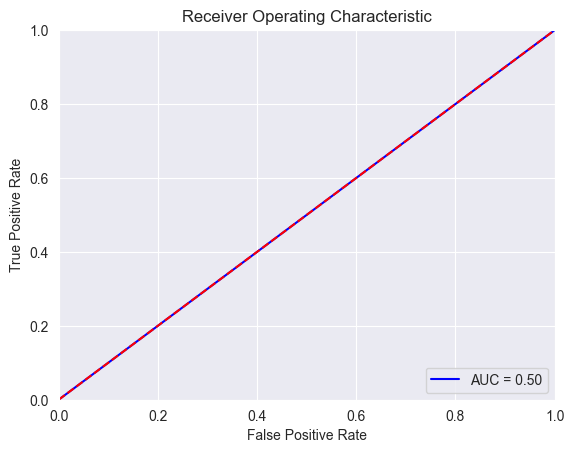

Normalized confusion matrix


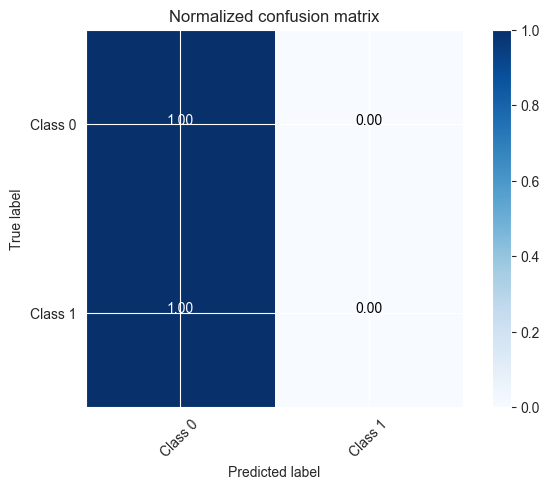

Metrics for the  Evaluation is {'accuracy': 0.7747536367902393, 'precision': 0.0, 'recall': 0.0, 'f1': 0.0}


In [119]:
nn_result = evaluate_model(y_test,np.argmax((NN_model.predict(X_test) > 0.5).astype("int32"), axis=-1))

Classification Report
              precision    recall  f1-score   support

           0       0.79      0.98      0.87      1651
           1       0.60      0.09      0.16       480

    accuracy                           0.78      2131
   macro avg       0.69      0.54      0.52      2131
weighted avg       0.75      0.78      0.71      2131


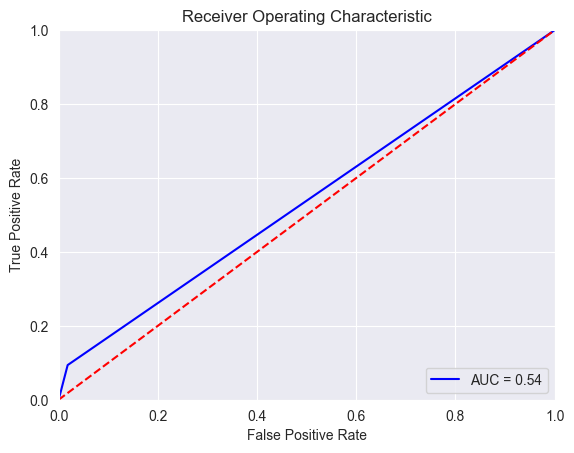

Normalized confusion matrix


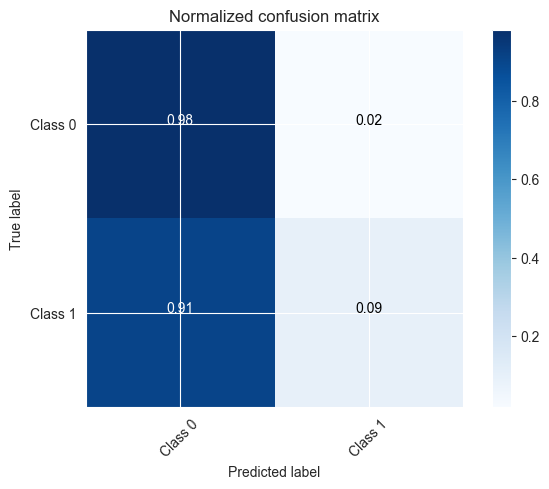

Metrics for the  Evaluation is {'accuracy': 0.7817925856405443, 'precision': 0.6, 'recall': 0.09375, 'f1': 0.16216216216216214}


In [89]:
catboost_result = evaluate_model(y_test, model1.predict(X_test))


Classification Report
              precision    recall  f1-score   support

           0       0.80      0.97      0.87      1651
           1       0.57      0.15      0.23       480

    accuracy                           0.78      2131
   macro avg       0.68      0.56      0.55      2131
weighted avg       0.75      0.78      0.73      2131


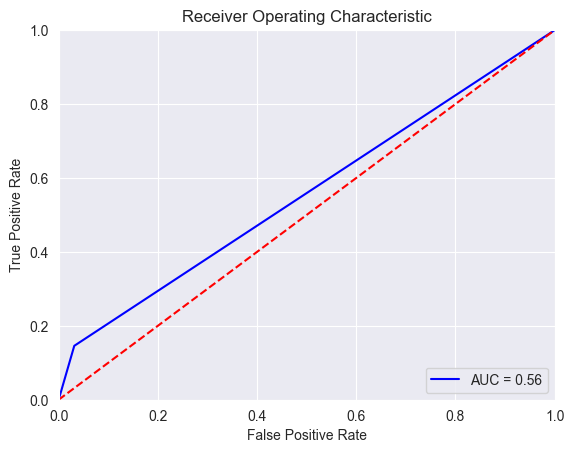

Normalized confusion matrix


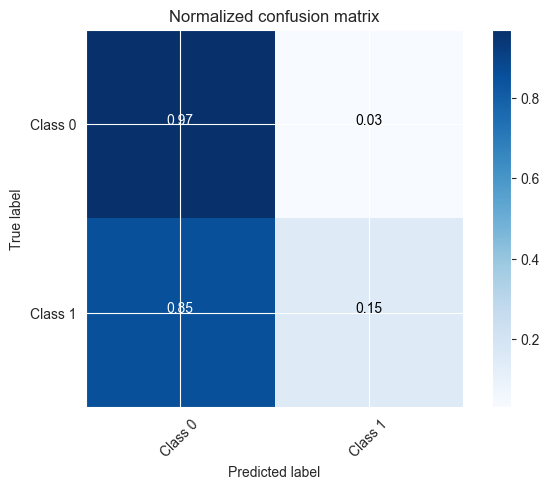

Metrics for the  Evaluation is {'accuracy': 0.7832003754106054, 'precision': 0.5737704918032787, 'recall': 0.14583333333333334, 'f1': 0.23255813953488372}


In [90]:
xgboost_result = evaluate_model(y_test, model2.predict(X_test))

Classification Report
              precision    recall  f1-score   support

           0       0.78      0.99      0.87      1651
           1       0.29      0.01      0.02       480

    accuracy                           0.77      2131
   macro avg       0.53      0.50      0.45      2131
weighted avg       0.67      0.77      0.68      2131


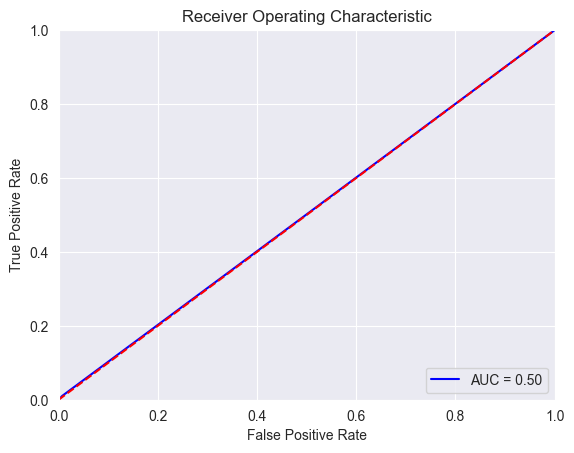

Normalized confusion matrix


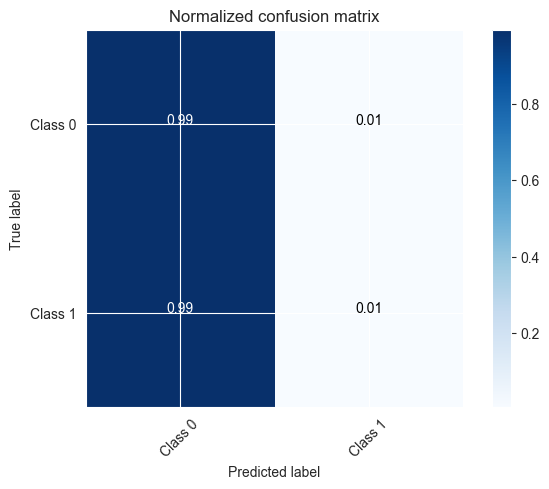

Metrics for the  Evaluation is {'accuracy': 0.7714687939934303, 'precision': 0.29411764705882354, 'recall': 0.010416666666666666, 'f1': 0.020120724346076455}


In [91]:
logistic_regression_result = evaluate_model(y_test, model.predict(X_test))

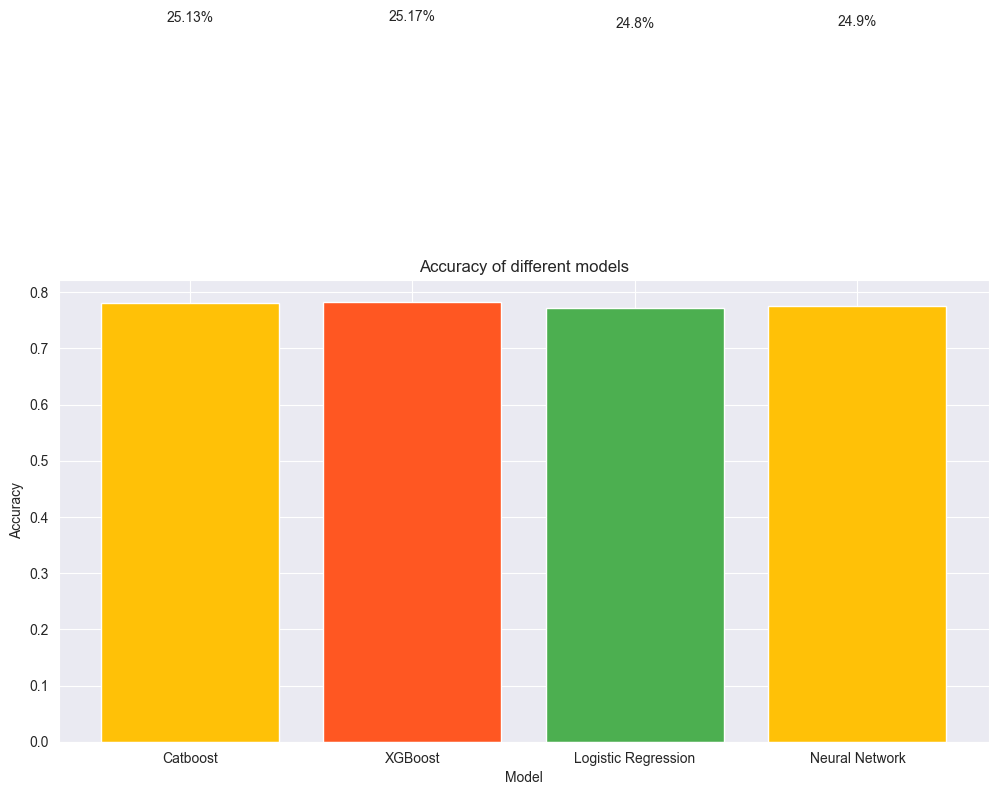

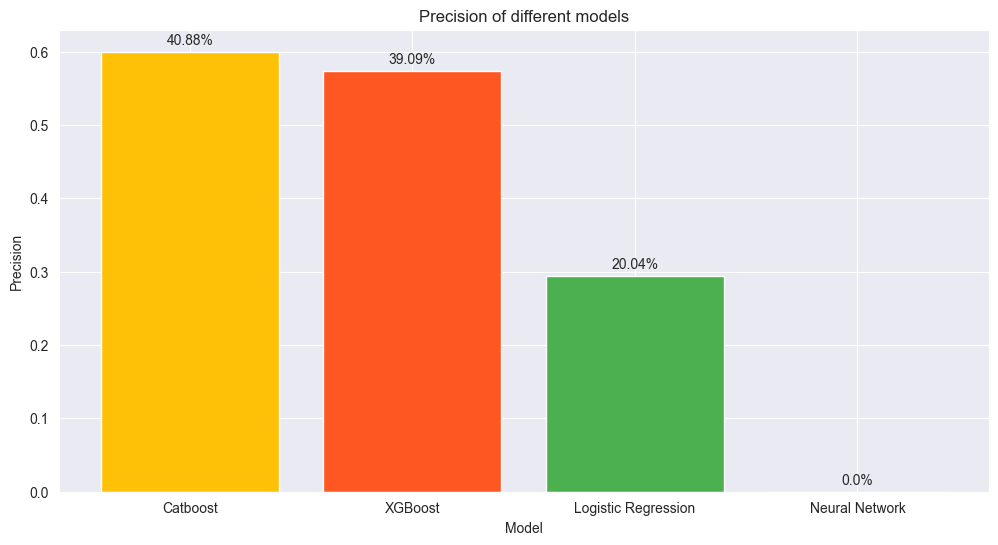

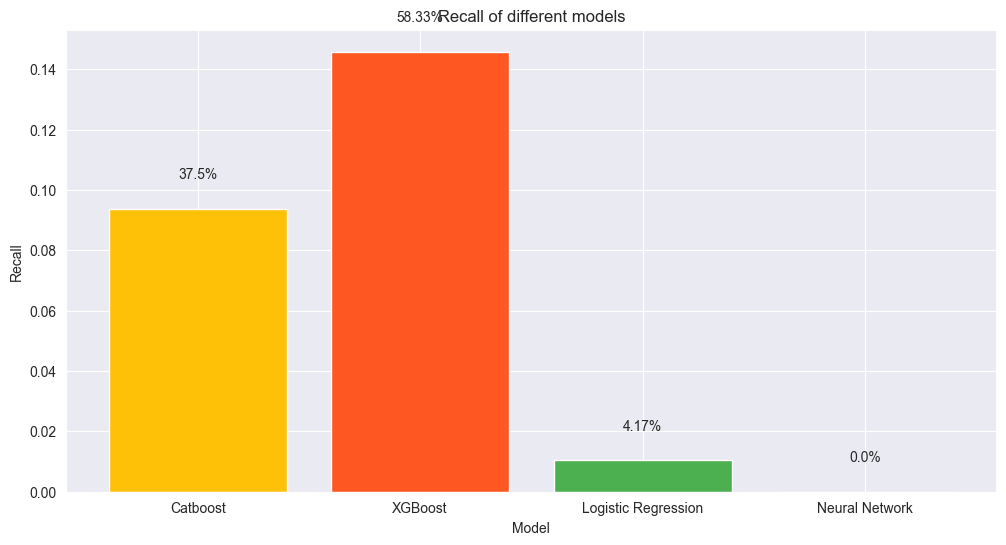

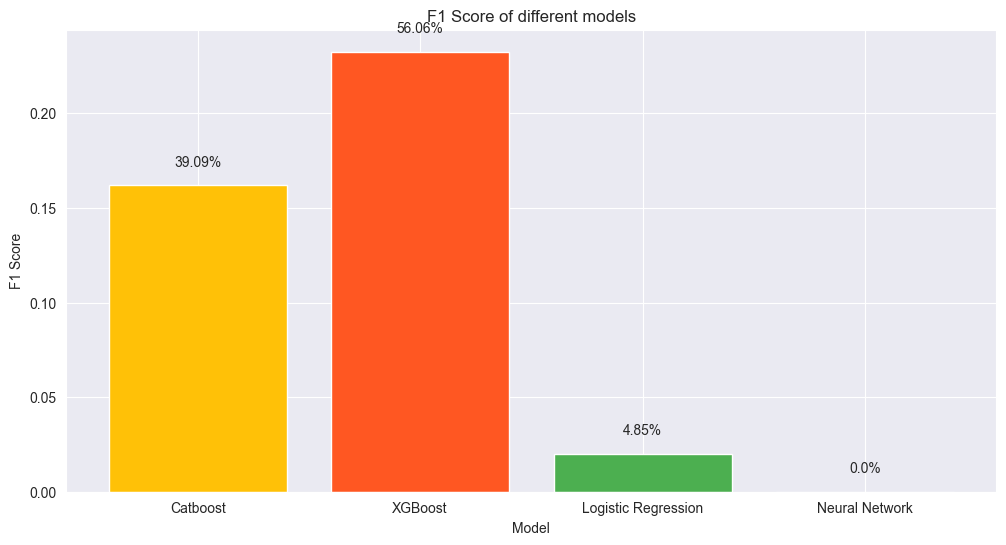

In [120]:
accuracy_list = [catboost_result['accuracy'], xgboost_result['accuracy'], logistic_regression_result['accuracy'], nn_result['accuracy']]
precision_list = [catboost_result['precision'], xgboost_result['precision'], logistic_regression_result['precision'], nn_result['precision']]
recall_list = [catboost_result['recall'], xgboost_result['recall'], logistic_regression_result['recall'], nn_result['recall']]
f1_list = [catboost_result['f1'], xgboost_result['f1'], logistic_regression_result['f1'], nn_result['f1']]

# Calculate percentages for accuracy list
total_accuracy = sum(accuracy_list)
accuracy_percentages = [round((accuracy / total_accuracy) * 100, 2) for accuracy in accuracy_list]

# Calculate percentages for precision list
total_precision = sum(precision_list)
precision_percentages = [round((precision / total_precision) * 100, 2) for precision in precision_list]

# Calculate percentages for recall list
total_recall = sum(recall_list)
recall_percentages = [round((recall / total_recall) * 100, 2) for recall in recall_list]

# Calculate percentages for f1 list
total_f1 = sum(f1_list)
f1_percentages = [round((f1 / total_f1) * 100, 2) for f1 in f1_list]

# Set colors for the bars
colors = ['#FFC107', '#FF5722', '#4CAF50']

# Plot for accuracy list with percentages
plt.figure(figsize=(12, 6))
plt.bar(['Catboost', 'XGBoost', 'Logistic Regression','Neural Network'], accuracy_list, color=colors)
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Accuracy of different models')

# Add percentage labels to the bars
for i, accuracy in enumerate(accuracy_list):
    plt.text(i, accuracy + 0.5, f"{accuracy_percentages[i]}%", ha='center')

plt.show()

# Plot for precision list with percentages
plt.figure(figsize=(12, 6))
plt.bar(['Catboost', 'XGBoost', 'Logistic Regression','Neural Network'], precision_list, color=colors)
plt.xlabel('Model')
plt.ylabel('Precision')
plt.title('Precision of different models')

# Add percentage labels to the bars
for i, precision in enumerate(precision_list):
    plt.text(i, precision + 0.01, f"{precision_percentages[i]}%", ha='center')

plt.show()

# Plot for recall list with percentages
plt.figure(figsize=(12, 6))
plt.bar(['Catboost', 'XGBoost', 'Logistic Regression','Neural Network'], recall_list, color=colors)
plt.xlabel('Model')
plt.ylabel('Recall')
plt.title('Recall of different models')

# Add percentage labels to the bars
for i, recall in enumerate(recall_list):
    plt.text(i, recall + 0.01, f"{recall_percentages[i]}%", ha='center')

plt.show()

# Plot for f1 list with percentages
plt.figure(figsize=(12, 6))
plt.bar(['Catboost', 'XGBoost', 'Logistic Regression','Neural Network'], f1_list, color=colors)
plt.xlabel('Model')
plt.ylabel('F1 Score')
plt.title('F1 Score of different models')

# Add percentage labels to the bars
for i, f1 in enumerate(f1_list):
    plt.text(i, f1 + 0.01, f"{f1_percentages[i]}%", ha='center')

plt.show()